**Classification By Sex**

Dans cette partie, nous allons s'intéresser à la prédiction de sexe de la personne à partir des Deep features calculées par le modèle FaceNet pré-entrainé. 
Dans un premier instant, on va essayer de voir les performances d'un classifier simple : par exemple un SVM et ensuite trouver des méthodes qui permettent d'améliorer la précision de la prédiction du genre du personne.

In [1]:
# importation des bibliotheques
import numpy as np   
import pandas as pd   
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from time import time
from sklearn.svm import SVC
import seaborn as sns

In [2]:
# describition du tableau
df = pd.read_csv("age_gender.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [ ]:
# charger les matrices de données (Deep features) : X et label : y
#X = np.load('features.npz')['arr_0']
X = pd.read_csv('features.csv', sep=',')
y = df.gender.values
del df # supprimer le Dataframe du fichier csv

In [5]:
# affichage les dimensions des matrices de X et y
print("taille de X :", X.shape)
print("taille de y :", y.shape)

(23705, 1792)

In [7]:
# preparation des deux ensembles de train (67%) et de test (33%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.333,
                                                    random_state=42, stratify = y)

les métriques utilisées pour l'évaluation des performances du modèles sont : 
- la sensibilité ou [précision](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel) 
- la spécificité ou [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall)
- l'accuracy
- AUC (Aera Under Curve)

In [8]:
def sensibility(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1] 
    fn = cm[1, 0] 
    tp = cm[1, 1]

    return tp/(tp+fn)

def specificity(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1] 
    fn = cm[1, 0] 
    tp = cm[1, 1]

    return tn/(tn+fp)

Ensuite, on va evaluer les performances du modèle sans faire un grid search vu que pour 2 Validation croisées ça prend plus de 50min d'apprentissage. 

In [9]:
#SVM
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'C': [100 ],#, 1e2 ,1e3, 5e3,1e4, 5e3, 1e4, 5e4, 1e5
              'gamma': [0.0001], #, 0.0005, 0.001, 0.005, 0.01
              'kernel' : ['rbf'],}

scoring = {'AUC': 'roc_auc', 'score': 'accuracy',
           'sensib' : sensibility, 'spec' : specificity}

clf = GridSearchCV(
    SVC(class_weight='balanced'), param_grid,
    cv=2, scoring=scoring, refit='AUC', return_train_score=True
)
clf = clf.fit(X_train, y_train)


print("done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 55min 28s
Best estimator found by grid search:
SVC(C=100, class_weight='balanced', gamma=0.0001)


les résultats : l'accuracy est de 70%, un score pas très motivant ! 

done in 2min 57s
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      4126
           1       0.70      0.63      0.66      3768

    accuracy                           0.70      7894
   macro avg       0.70      0.69      0.69      7894
weighted avg       0.70      0.70      0.69      7894



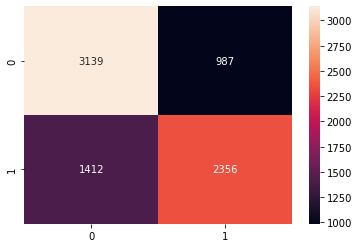

In [10]:
t0 = time()
y_pred = clf.predict(X_test)
print("done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=range(2))

sns.heatmap(cm, annot=True, fmt='d')